In [1]:
import numpy as np 
import numpy.random as npr
import networkx as nx
import matplotlib as plt
import plotly.graph_objects as go
import pydtmc
import sys 
sys.path.append("./modules/")
from markov import *
import graphviz

In [2]:
# variables

alpha = 0.8
beta = 0.2
u1 = 15
u2 = 75
thinkTime = 5000
timeSlice = 3
Sio1 = 40
Sio2 = 180
qio1 = 0.65 #route to io1
qio2 = 0.25 # route to io2
qoutd = 0.1*0.4 #go to delay station
qouts = 0.1*0.6 # renter the system

In [3]:

def stage_enumerator(stage: int) -> list[State]:
    Ndelay = 0
    Ncpu = 1
    Nio1 = 2
    Nio2 = 3
    cpuStage = stage
    stages = [0,0,0,0]
    result = []
    while stages[Ndelay] <= 3:
        for i in reversed(range(4)):
            stages[i] += 1
            if stages[i] <= 3: break
            elif i > 0 : stages[i] = 0
            pass
        state= State(stages[Ndelay], stages[Ncpu], stages[Nio1],stages[Nio2],stage)
        if state.isValid(): result.append(state)
        pass
    return result

def node_enumerator() -> list[State]:
    nodes = stage_enumerator(1)
    for newnode in stage_enumerator(2):
        if newnode not in nodes:
            nodes.append(newnode)
            pass
        pass
    return nodes

nodes =node_enumerator()
print(list(map(lambda x : str(x),nodes)))
print(len(nodes))

['0,0,0,3', '0,0,1,2', '0,0,2,1', '0,0,3,0', '0,1.1,0,2', '0,1.1,1,1', '0,1.1,2,0', '0,2.1,0,1', '0,2.1,1,0', '0,3.1,0,0', '1,0,0,2', '1,0,1,1', '1,0,2,0', '1,1.1,0,1', '1,1.1,1,0', '1,2.1,0,0', '2,0,0,1', '2,0,1,0', '2,1.1,0,0', '3,0,0,0', '0,0,0,3', '0,0,1,2', '0,0,2,1', '0,0,3,0', '0,1.2,0,2', '0,1.2,1,1', '0,1.2,2,0', '0,2.2,0,1', '0,2.2,1,0', '0,3.2,0,0', '1,0,0,2', '1,0,1,1', '1,0,2,0', '1,1.2,0,1', '1,1.2,1,0', '1,2.2,0,0', '2,0,0,1', '2,0,1,0', '2,1.2,0,0', '3,0,0,0']
40


In [4]:
def edge_enumerator() -> list[tuple[State,State]]:
    nodes = node_enumerator()
    result = []
    for head in nodes:
        for tail in nodes:
            if Transition(head,tail).type != Transition.TransitionType.UNKNOWN and not (head,tail) in result:
                result.append((head,tail))
                pass
            pass
        pass
    return result

print(list(map(lambda x:("{}->{}".format(str(x[0]), str(x[1]))),edge_enumerator())))

['0,0,0,3->0,1.1,0,2', '0,0,0,3->0,1.2,0,2', '0,0,1,2->0,1.1,0,2', '0,0,1,2->0,1.1,1,1', '0,0,1,2->0,1.2,0,2', '0,0,1,2->0,1.2,1,1', '0,0,2,1->0,1.1,1,1', '0,0,2,1->0,1.1,2,0', '0,0,2,1->0,1.2,1,1', '0,0,2,1->0,1.2,2,0', '0,0,3,0->0,1.1,2,0', '0,0,3,0->0,1.2,2,0', '0,1.1,0,2->0,0,0,3', '0,1.1,0,2->0,0,1,2', '0,1.1,0,2->0,1.1,0,2', '0,1.1,0,2->0,2.1,0,1', '0,1.1,0,2->1,0,0,2', '0,1.1,0,2->0,0,0,3', '0,1.1,0,2->0,0,1,2', '0,1.1,0,2->0,1.2,0,2', '0,1.1,0,2->1,0,0,2', '0,1.1,1,1->0,0,1,2', '0,1.1,1,1->0,0,2,1', '0,1.1,1,1->0,1.1,1,1', '0,1.1,1,1->0,2.1,0,1', '0,1.1,1,1->0,2.1,1,0', '0,1.1,1,1->1,0,1,1', '0,1.1,1,1->0,0,1,2', '0,1.1,1,1->0,0,2,1', '0,1.1,1,1->0,1.2,1,1', '0,1.1,1,1->1,0,1,1', '0,1.1,2,0->0,0,2,1', '0,1.1,2,0->0,0,3,0', '0,1.1,2,0->0,1.1,2,0', '0,1.1,2,0->0,2.1,1,0', '0,1.1,2,0->1,0,2,0', '0,1.1,2,0->0,0,2,1', '0,1.1,2,0->0,0,3,0', '0,1.1,2,0->0,1.2,2,0', '0,1.1,2,0->1,0,2,0', '0,2.1,0,1->0,1.1,0,2', '0,2.1,0,1->0,1.1,1,1', '0,2.1,0,1->0,2.1,0,1', '0,2.1,0,1->0,3.1,0,0', '0,

legend (Delay_station,CPU.Stage,IO1,IO2)


Warning redundant edge 0,1.1,0,2 , 0,0,0,3 , call N 0, inW 0.01667, newW0.016666666666666666
Warning redundant edge 0,1.1,0,2 , 0,0,1,2 , call N 0, inW 0.04333, newW0.043333333333333335
Warning redundant edge 0,1.1,0,2 , 1,0,0,2 , call N 0, inW 0.00267, newW0.002666666666666667
Warning redundant edge 0,1.1,1,1 , 0,0,1,2 , call N 0, inW 0.01667, newW0.016666666666666666
Warning redundant edge 0,1.1,1,1 , 0,0,2,1 , call N 0, inW 0.04333, newW0.043333333333333335
Warning redundant edge 0,1.1,1,1 , 1,0,1,1 , call N 0, inW 0.00267, newW0.002666666666666667
Warning redundant edge 0,1.1,2,0 , 0,0,2,1 , call N 0, inW 0.01667, newW0.016666666666666666
Warning redundant edge 0,1.1,2,0 , 0,0,3,0 , call N 0, inW 0.04333, newW0.043333333333333335
Warning redundant edge 0,1.1,2,0 , 1,0,2,0 , call N 0, inW 0.00267, newW0.002666666666666667
Warning redundant edge 1,1.1,0,1 , 1,0,0,2 , call N 0, inW 0.01667, newW0.016666666666666666
Warning redundant edge 1,1.1,0,1 , 1,0,1,1 , call N 0, inW 0.04333, ne

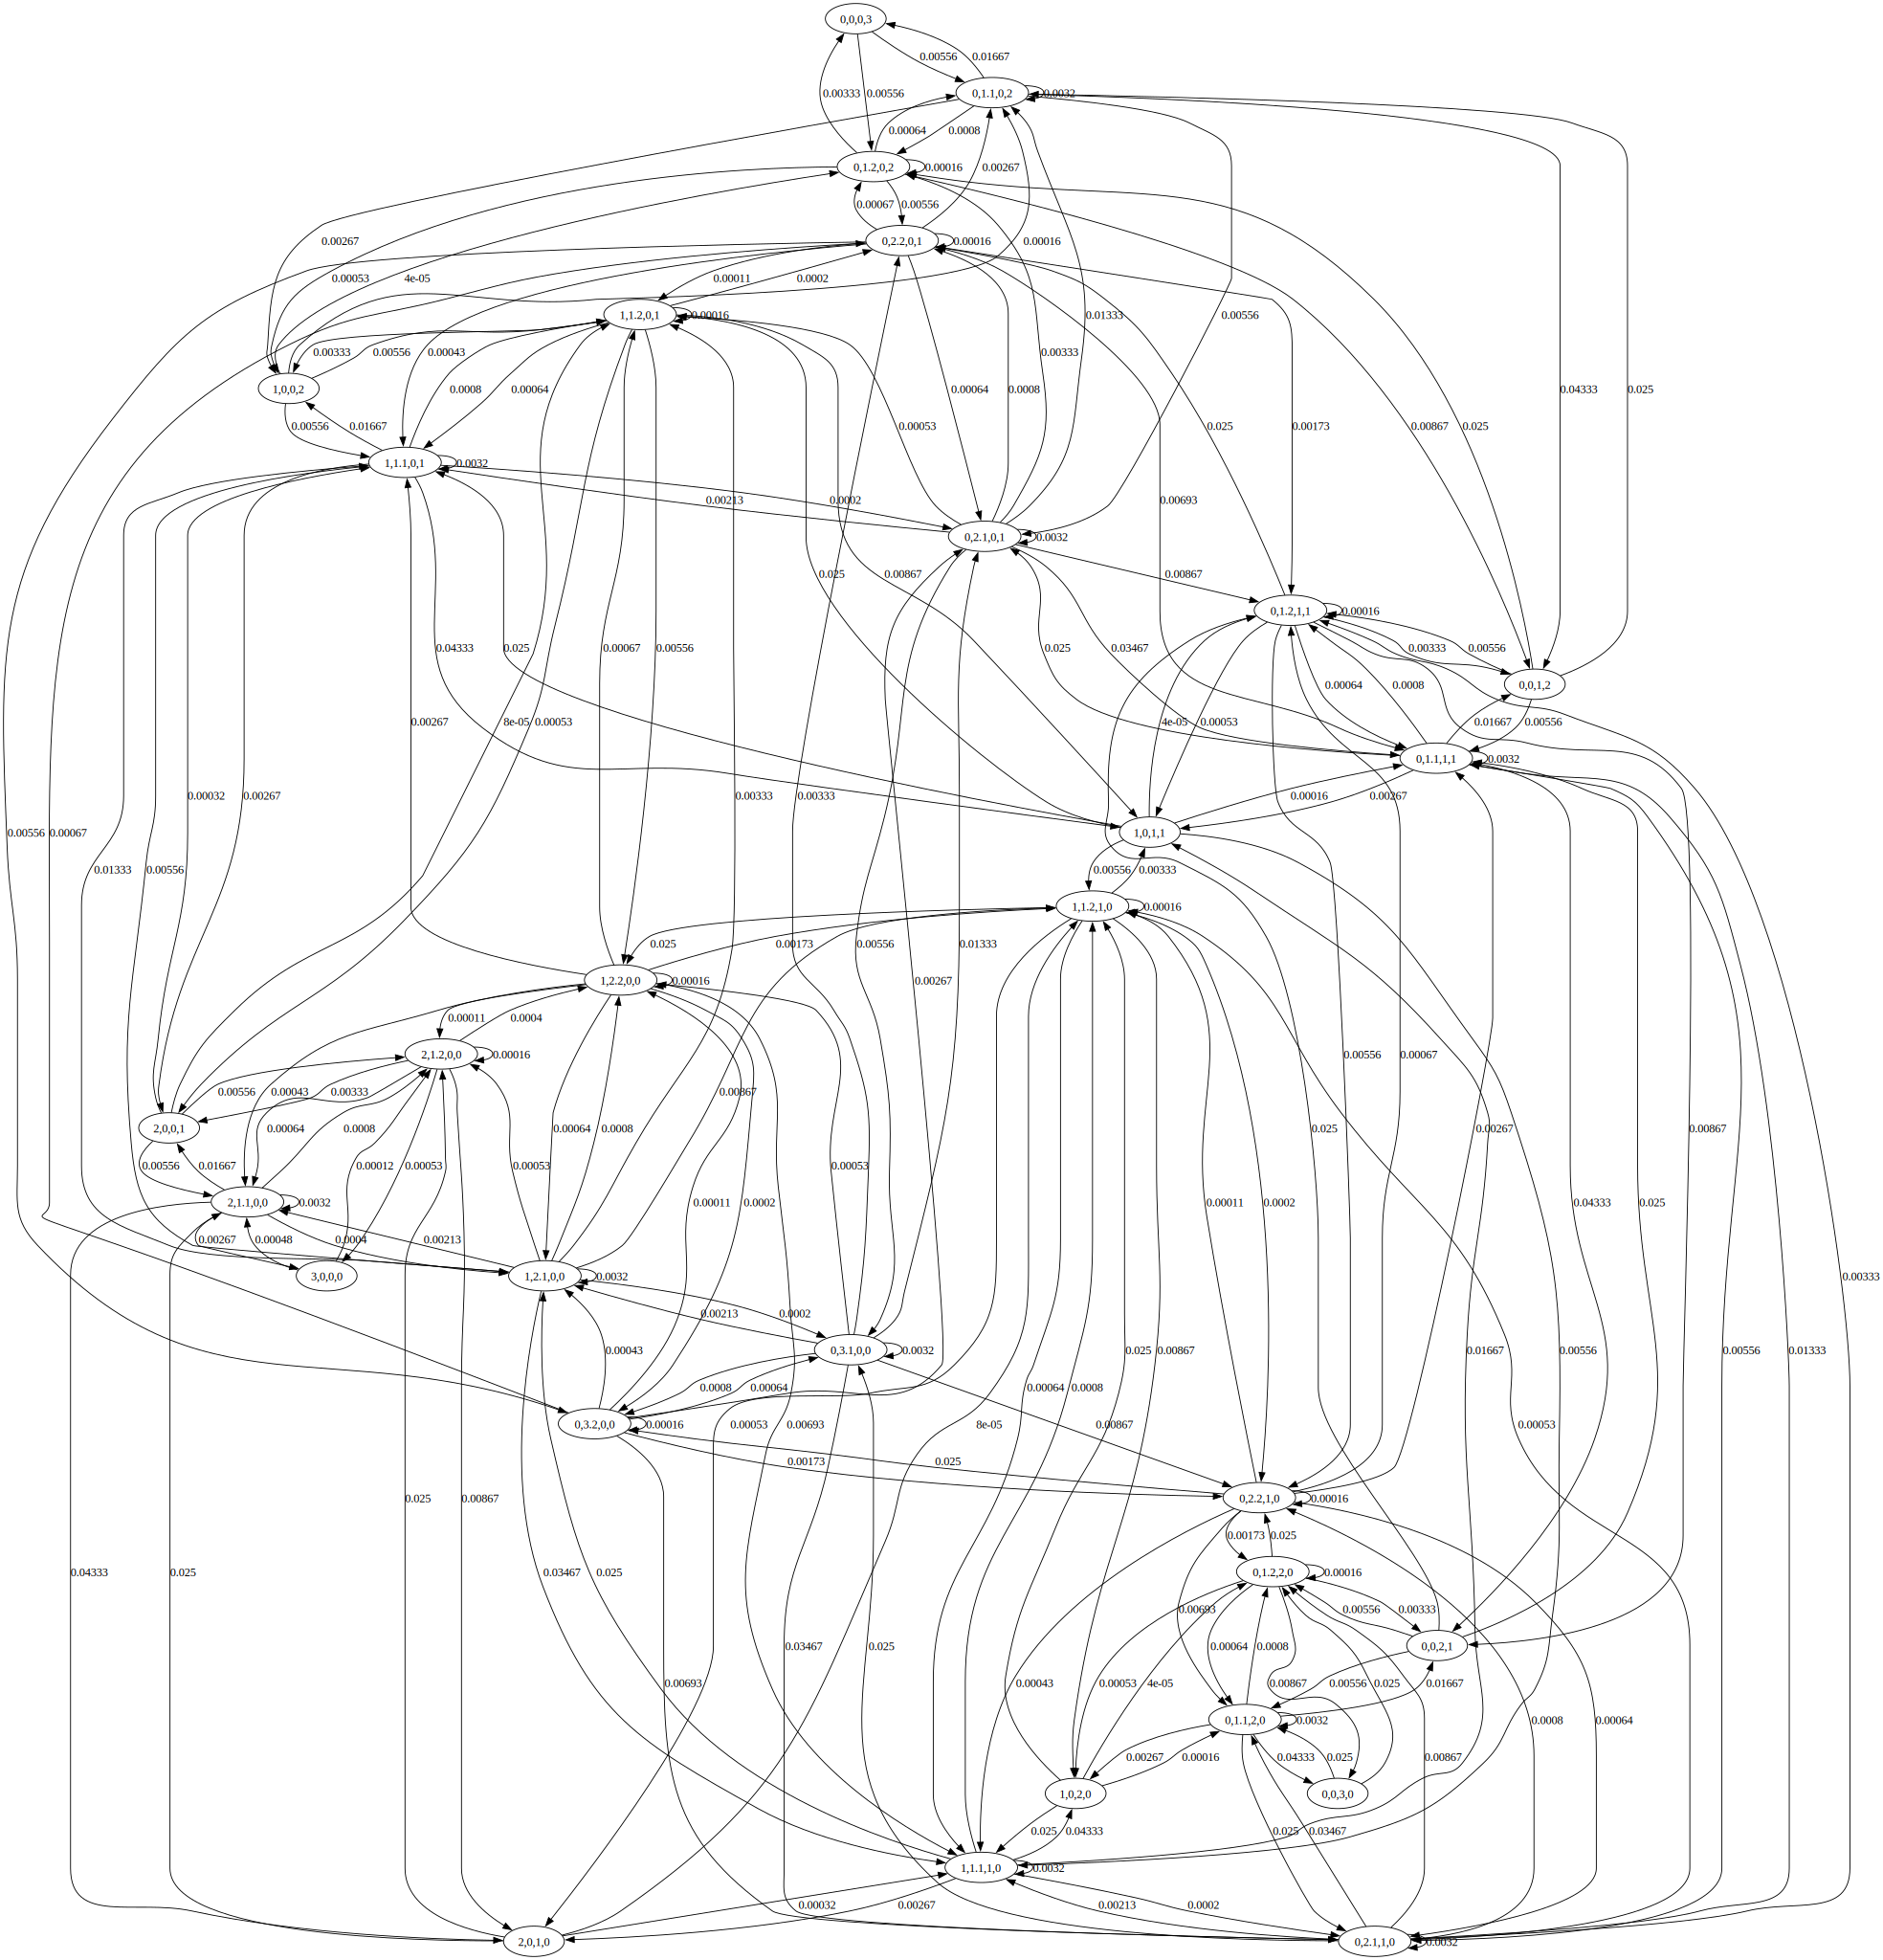

In [5]:
chain = DiGraph()

nodes = list(map(lambda x:str(x),node_enumerator()))
edges = edge_enumerator()

for node in nodes:
    chain.add_node(node)
    pass

for edge in edges:
    tr = Transition(edge[0],edge[1])
    if tr.type != Transition.TransitionType.UNKNOWN:
        chain.add_edge(str(edge[0]),str(edge[1]),tr.p())
    pass


chain.gviz()

In [9]:
mat = np.zeros((len(nodes),len(nodes)))
adj :dict = chain.graph.adj
for i in range(len(nodes)):
    ref = nodes[i]
    for j in range(len(nodes)):
        to = nodes[j]
        if to in adj[ref]:
            mat[i][j] = adj[ref][to]["weight"]
        pass
    pass
pass

mat = mat.transpose()
for i in range(len(mat)):
    print("row:{}, sum:{}".format(i,mat[i].sum()))

    pass
print(mat)

row:0, sum:0.02
row:1, sum:0.072
row:2, sum:0.072
row:3, sum:0.052000000000000005
row:4, sum:0.08128
row:5, sum:0.12288
row:6, sum:0.10688
row:7, sum:0.050600000000000006
row:8, sum:0.0762
row:9, sum:0.034600000000000006
row:10, sum:0.0232
row:11, sum:0.0752
row:12, sum:0.0552
row:13, sum:0.08416000000000001
row:14, sum:0.10976000000000001
row:15, sum:0.037360000000000004
row:16, sum:0.0232
row:17, sum:0.055200000000000006
row:18, sum:0.06848
row:19, sum:0.0032
row:20, sum:0.02
row:21, sum:0.072
row:22, sum:0.072
row:23, sum:0.052000000000000005
row:24, sum:0.06616
row:25, sum:0.07656000000000002
row:26, sum:0.07256
row:27, sum:0.03572
row:28, sum:0.042120000000000005
row:29, sum:0.03172
row:30, sum:0.0232
row:31, sum:0.0752
row:32, sum:0.0552
row:33, sum:0.06688
row:34, sum:0.07328
row:35, sum:0.03256
row:36, sum:0.0232
row:37, sum:0.055200000000000006
row:38, sum:0.06296
row:39, sum:0.0032
[[0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.

In [7]:
dtmc = pydtmc.MarkovChain(mat)

ValidationError: The "p" parameter rows must sum to 1.0.

In [ ]:

(chain
("3,0,0,0","2,1.1,0,0",(1/thinkTime)*alpha*3, (1/u1)*qoutd)
(chain.last_tail,"1,2.1,0,0",(1/thinkTime)*2,(1/u1)*qoutd*alpha)
(chain.last_tail,"0,3.1,0,0",(1/thinkTime),(1/u1)*qoutd*alpha)
("3,0,0,0","2,1.2,0,0",(1/thinkTime)*beta*3,(1/u2)*qoutd)
(chain.last_tail,"1,2.2,0,0",(1/thinkTime)*2,(1/u2)*beta*qoutd)
(chain.last_tail,"0,3.2,0,0",(1/thinkTime),(1/u2)*beta*qoutd)
("0,3.1,0,0","0,2.1,1,0", (1/u1)*alpha*qio1,(1/u1)*alpha*qouts) 
(chain.last_tail, "0,1.1,2,0", (1/u1)*alpha*qio1,(1/Sio1))
(chain.last_tail, "0,0,3,0",(1/u1)*alpha*qio1,(1/Sio1))
("0,0,3,0","0,1.2,2,0",(1/Sio1)*beta,(1/u2)*qio1)
(chain.last_tail,"0,2.2,1,0",(1/Sio1),(1/u2)*qio2)
(chain.last_tail, "0,3.2,0,0",(1/Sio1),(1/u2)*qio1*beta)
("0,3.2,0,0","0,2.1,1,0",(1/u2)*alpha*qio1)
(chain.last_tail,"0,1.2,2,0",(1/u1)*beta*qio1)
("0,3.1,0,0","0,2.1,0,1",(1/u1)*alpha*qio2)
(chain.last_tail,"0,1.1,0,2",(1/u1)*alpha*qio2)
(chain.last_tail,"0,0,0,3",(1/u1)*alpha*qio2)
("0,3.2,0,0","0,2.2,0,1",(1/u2)*beta*qio2)
(chain.last_tail,"0,1.2,0,2",(1/u2)*beta*qio2)
(chain.last_tail,"0,0,0,3",(1/u2)*beta*qio2)
("0,3.2,0,0","0,2.1,0,1",(1/u2)*alpha*qio2)
(chain.last_tail,"0,1.2,0,2",(1/u2)*beta*qio2)
("0,3.1,0,0","0,2.2,0,1",(1/u1)*beta*qio2)
(chain.last_tail,"0,1.1,0,2",(1/u2)*alpha*qio2)
("0,1.1,0,2","0,0,1,2",(1/u1)*qio1)
("0,1.2,0,2","0,0,1,2",(1/u2)*qio1)
("0,1.1,2,0","0,0,2,1",(1/u1)*qio2)
("0,1.2,2,0","0,0,2,1",(1/u2)*qio2)
("0,2.2,1,0","0,1.2,1,1",(1/u2)*beta*qio2)
("0,2.2,1,0","0,1.1,1,1", (1/u2)*alpha*qio2)
("0,1.1,1,1","0,0,2,1",(1/u1)*qio1)
("0,1.2,1,1","0,0,2,1",(1/u2)*qio1)
("0,1.1,0,2","1,0,0,2",(1/u1)*qoutd)
("1,2.1,0,0","2,1.1,0,0",(1/u1)*alpha*qoutd)
("0,3.1,0,0","1,2.1,0,0",(1/u1)*alpha*qoutd)
("0,1.2,2,0","0,0,3,0",(1/u2)*qio1)
("0,0,2,1","0,1.1,2,0",(1/Sio2)*alpha*qouts)
("0,0,2,1","0,1.2,2,0",(1/Sio2)*qouts*alpha)
)

: 